<a href="https://colab.research.google.com/github/j-min/VL-T5/blob/main/inference_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VL-T5 inference on custom images

## Download code and install dependencies

In [1]:
!git clone https://github.com/j-min/VL-T5

Cloning into 'VL-T5'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 184 (delta 95), reused 154 (delta 73), pack-reused 0
Receiving objects: 100% (184/184), 897.61 KiB | 22.44 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [2]:
cd VL-T5

/content/VL-T5


In [3]:
!pip uninstall param -y # to resolve name conflict with src.param.py
!pip install -r requirements.txt
!python download_backbones.py

Uninstalling param-1.10.1:
  Successfully uninstalled param-1.10.1
  Cloning git://github.com/j-min/language-evaluation (to revision master) to /tmp/pip-req-build-kkr_ggfz
  Running command git clone -q git://github.com/j-min/language-evaluation /tmp/pip-req-build-kkr_ggfz
     |████████████████████████████████| 748.8MB 15kB/s 
     |████████████████████████████████| 1.8MB 36.2MB/s 
     |████████████████████████████████| 1.2MB 29.1MB/s 
     |████████████████████████████████| 1.8MB 26.8MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 5.9MB 39.6MB/s 
     |████████████████████████████████| 901kB 45.3MB/s 
     |████████████████████████████████| 2.9MB 20.0MB/s 
     |████████████████████████████████| 174kB 57.6MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-an

## Download the pretrained checkpoint

In [4]:
import gdown

In [5]:
!mkdir -p VL-T5/snap/pretrain/VLT5

In [6]:
gdown.download('https://drive.google.com/uc?id=100qajGncE_vc4bfjVxxICwz3dwiAxbIZ', 'VL-T5/snap/pretrain/VLT5/Epoch30.pth', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=100qajGncE_vc4bfjVxxICwz3dwiAxbIZ
To: /content/VL-T5/VL-T5/snap/pretrain/VLT5/Epoch30.pth
898MB [00:10, 87.7MB/s]


'VL-T5/snap/pretrain/VLT5/Epoch30.pth'

## Add source code path

In [7]:
import sys

In [8]:
sys.path.append('/content/VL-T5/VL-T5/src')
sys.path.append('/content/VL-T5/VL-T5/inference')

In [9]:
cd VL-T5

/content/VL-T5/VL-T5


## Build a model and load weights from the pretrained checkpoint

In [10]:
!pip uninstall param -y

In [11]:
from param import parse_args

In [12]:
args = parse_args(
    parse=False,
    backbone='t5-base',
    load='snap/pretrain/VLT5/Epoch30'
)
args.gpu = 0

In [13]:
from vqa import Trainer

In [14]:
trainer = Trainer(args,
                  train=False
                  )


Building Model at GPU 0


Some weights of VLT5VQA were not initialized from the model checkpoint at t5-base and are newly initialized: ['encoder.visual_embedding.feat_embedding.0.weight', 'encoder.visual_embedding.feat_embedding.0.bias', 'encoder.visual_embedding.feat_embedding.1.weight', 'encoder.visual_embedding.absolute_vis_pos_embedding.0.weight', 'encoder.visual_embedding.absolute_vis_pos_embedding.0.bias', 'encoder.visual_embedding.absolute_vis_pos_embedding.1.weight', 'encoder.visual_embedding.obj_order_embedding.weight', 'encoder.visual_embedding.img_order_embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from  snap/pretrain/VLT5/Epoch30.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['encoder.visual_embedding.layer_norm.weight'])
Model Launching at GPU 0
It took 10.4s


# Faster R-CNN inference script (from [Huggingface transformers LXMERT demo](https://github.com/huggingface/transformers/tree/master/examples/research_projects/lxmert))

In [15]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from inference.processing_image import Preprocess
from inference.visualizing_image import SingleImageViz
from inference.modeling_frcnn import GeneralizedRCNN
from inference.utils import Config, get_data

import wget
import pickle
import os


URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

objids = get_data(OBJ_URL) 
attrids = get_data(ATTR_URL)
gqa_answers = get_data(GQA_URL) 
vqa_answers = get_data(VQA_URL) 
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg) 
image_preprocess = Preprocess(frcnn_cfg) 

# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml /root/.cache/torch/transformers/tmp2hiwish2



loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmpeamu3hf1



loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [16]:
image_filename = wget.download(URL)

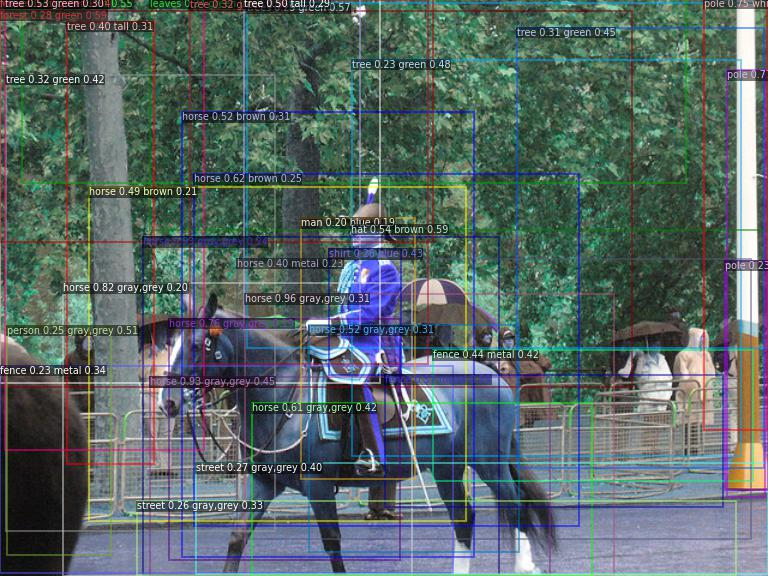

In [17]:
image_dirname = image_filename
frcnn_visualizer = SingleImageViz(image_filename, id2obj=objids, id2attr=attrids) 

images, sizes, scales_yx = image_preprocess(image_filename) 

output_dict = frcnn(
    images, 
    sizes, 
    scales_yx = scales_yx, 
    padding = 'max_detections', 
    max_detections = frcnn_cfg.max_detections, 
    return_tensors = 'pt' 
)

# add boxes and labels to the image 
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"), 
    output_dict.get("obj_ids"),
    output_dict.get("obj_probs"),
    output_dict.get("attr_ids"), 
    output_dict.get("attr_probs"),
)

showarray(frcnn_visualizer._get_buffer())

normalized_boxes = output_dict.get("normalized_boxes") 
features = output_dict.get("roi_features") 

## Load Tokenizer

In [18]:
from tokenization import VLT5TokenizerFast

In [19]:
tokenizer = VLT5TokenizerFast.from_pretrained('t5-base')

## Inference

In [20]:
questions = ["vqa: What is the main doing?", 
             "vqa: What color is the clothing the man wears?", 
             "vqa: What color is the horse?",] 

In [21]:
for question in questions:
    input_ids = tokenizer(question, return_tensors='pt', padding=True).input_ids
    batch = {}
    batch['input_ids'] = input_ids
    batch['vis_feats'] = features
    batch['boxes'] = normalized_boxes

    result = trainer.model.test_step(batch)
    print(f"Q: {question}")
    print(f"A: {result['pred_ans'][0]}")

Q: vqa: What is the main doing?
A: riding
Q: vqa: What color is the clothing the man wears?
A: blue
Q: vqa: What color is the horse?
A: black
